In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import sys

np.random.seed(17)

# Preparation of training and validation datasets

The data was taken from <a href="https://www.kaggle.com/c/digit-recognizer/data">kaggle competition</a>

In [2]:
train_size = 37000
validation_size = 5000

In [3]:
# Read data from file
data = np.genfromtxt('mnist/train.csv', delimiter=',', skip_header=1)
data.shape

(42000, 785)

In [4]:
# In this dataset image sizes is 28x28 but we need 32x32 so we just add zeros
# on the sides of each image using np.pad
# This is parameter for the function
# First and second tuples are for examples and layers 
# third and fourth are for rows and columns of images
padding = ((0, 0), (0, 0), (2, 2), (2, 2))

In [5]:
# Reshape data and add one more axis for image channels
# images are black and white so there is only one channel (black and white - 1, rgb - 3, rgba - 4)
# First column is answers so you should skip it
# We also normalize the values by dividing by 255
x_train = data[:train_size, 1:].reshape((train_size, 1, 28, 28)) / 255 
x_train = np.pad(x_train, padding) # Make it 32x32
x_train.shape

(37000, 1, 32, 32)

In [6]:
# Extract answers
y_train = data[:train_size, :1]
y_train.shape

(37000, 1)

In [7]:
# Do the same with the validation part of the dateset
x_validation = data[train_size:train_size + validation_size, 1:].reshape((validation_size, 1, 28, 28)) / 255
x_validation = np.pad(x_validation, padding) # Make it 32x32
x_validation.shape

(5000, 1, 32, 32)

In [8]:
# Extract answers
y_validation = data[train_size:train_size + validation_size, :1]
y_validation.shape

(5000, 1)

array([1.])

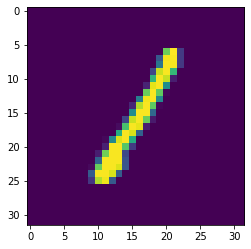

In [9]:
# Example
example_number = 745

plt.imshow(x_train[example_number, 0])
y_train[example_number]

# Convolution 

In [10]:
# Performs convolution layer
# Supports only square kernels
# Kernels, masks, filters are the same thing in terms of cnn
# It's cross-correlation, to be precise
class Convolution:
    def __init__(self, kernel_size, input_channels, output_channels, stride=1):
        self.kernel_size = kernel_size # Size of kernels
        self.input_channels = input_channels # Number of channels in input images
        self.output_channels = output_channels # Number of channels in output images
        self.stride = stride
        
        # Generate paramters of convolution layer
        # Shape of weights is 
        #             (number of channels in the resulting image, number of channels in the input image, 
        #              kernel_size, kernel_size)
        # Shape of biases is (number of channels in the resulting image, number of channels in the input image)
        #             one bias for each kernel
        # Random numbers from -0.5 to 0.5
        self.weights = np.random.random((output_channels, input_channels,
                                         kernel_size, kernel_size)) - 0.5
        self.biases  = np.random.random((output_channels, input_channels)) - 0.5
        
        # Save the number of layer parameters
        # We use it only when recover network parameters from file
        self.n_parameters = self.weights.size + self.biases.size
        
        
    # Performs forward pass of a convolution layer
    def forward(self, x):
        # Shape of x is (number of examples, number of channels in the input images,
        # number of rows in image, number of columns in image)
        n_examples, input_channels, img_rows, img_columns = x.shape
        
        # Save input shape (for backpropagation)
        self.input_shape = x.shape
        
        # Calculate number of rows and columns in output images 
        out_rows = (img_rows - self.kernel_size) // self.stride + 1 
        out_columns = (img_columns - self.kernel_size) // self.stride + 1
        # Create result matrix
        result = np.zeros((n_examples, self.output_channels, out_rows, out_columns))
        
        # Loop through the output channels of images
        for out_channel in range(self.output_channels):
            # Loop through the input channels
            for in_channel in range(self.input_channels):
                # Select current kernel
                current_kernel = self.weights[out_channel, in_channel]
                
                for i in range(out_rows):
                    for j in range(out_columns):
                        # Calculate coordinates of the current area
                        row_start = i * self.stride
                        row_end = i * self.stride + self.kernel_size
                        col_start = j * self.stride
                        col_end = j * self.stride + self.kernel_size
                        
                        # Select the current area for all examples
                        current_area = x[:, in_channel, row_start:row_end, col_start:col_end]
                        
                        # Shape of current_area is (number of examples, kernel size, kernel size)
                        # Shape of current_kernel is (kernel size, kernel size)
                        # Multiply current_area for each example by current_kernel
                        temp_result = current_kernel * current_area
                        
                        # Sum values for each example
                        # temp_result shape changed from (number of examples, kernel size, kernel size)
                        #                             to (number of examples, 1)
                        temp_result = np.sum(np.sum(temp_result, axis=1), axis=1)
                        
                        # Save result
                        result[:, out_channel, i, j] += temp_result
                        
                # Add bias (remember one bias for each kernel)
                result[:, out_channel] += self.biases[out_channel, in_channel]
                        
        return result
    
    
    # Performs backpropagation algorithm
    def update_parameters(self, error, prev_layer_act, lr):
        # Shape of error is (number of examples, number of channels in output of this layer, 
        #                    rows in output images, columns in output images)
        # Shape of prev_layer_act is (number of examples, number of channels in input of this layer, 
        #                         rows in input images, columns in input images)
        # lr is the learning rate
        
        error_channels, error_rows, error_cols = error.shape[1:]
        prev_channels = prev_layer_act.shape[1]
        
        # Loop through error channels (same as output channels)
        for error_channel in range(error_channels):
            for prev_channel in range(prev_channels):
                # Select current kernel from matrix (output channels, input channels)
                current_kernel = self.weights[error_channel, prev_channel]
                
                current_error = error[:, error_channel]
                current_prev_l_act = prev_layer_act[:, prev_channel]
                
                # Update biases
                self.biases[error_channel, prev_channel] -= lr * np.sum(current_error)
                
                for kernel_row in range(self.kernel_size):
                    for kernel_col in range(self.kernel_size):
                        for error_row in range(error_rows):
                            for error_col in range(error_cols):
                                # Select element from previous layer activation
                                row = error_row * self.stride + kernel_row
                                col = error_col * self.stride + kernel_col
                                elem_from_prev_l_act = current_prev_l_act[:, row, col]
                                
                                # Calculate derivative
                                derivative = np.sum(current_error[:, error_row, error_col] * elem_from_prev_l_act)
                                
                                # Update kernel
                                current_kernel[kernel_row, kernel_col] -= lr * derivative
                                    
    
    # Passes error through the convolution layer
    # This method only works when stride is 1
    # When stride is one backprop is almost the same as forward
    def fast_get_error(self, prev_error):
        # Shape of previous error is (number of examples, number of channels, rows, columns)
        p = self.kernel_size - 1
        prev_error = np.pad(prev_error, ((0, 0), (0, 0), (p, p), (p, p)))
        n_examples, prev_channels, prev_rows, prev_cols = prev_error.shape
        
        # Shape of new error is the same as the shape of input matrix
        error_channels, error_rows, error_cols = self.input_shape[1:]
        error = np.zeros((n_examples, error_channels, error_rows, error_cols))
        
        for prev_channel in range(prev_channels):
            for error_channel in range(error_channels):
                # We should rotate weights matrix 
                # You can find out more in this article: https://grzegorzgwardys.wordpress.com/2016/04/22/8/
                current_kernel = np.rot90(self.weights[prev_channel, error_channel], 2)
                
                for error_row in range(error_rows):
                    for error_col in range(error_cols):
                        # Calculate coordinates of the current area
                        row_start = error_row * self.stride
                        row_end = error_row * self.stride + self.kernel_size
                        col_start = error_col * self.stride
                        col_end = error_col * self.stride + self.kernel_size
                        
                        # Select the current area for all examples
                        current_area = prev_error[:, prev_channel, row_start:row_end, col_start:col_end]
                        
                        # Calculate result
                        # Shape of current_area is (number of examples, kernel size, kernel size)
                        # Shape of current_kernel is (kernel size, kernel size)
                        # Multiply current_area for each example by current_kernel
                        temp_result = current_kernel * current_area
                        
                        # Sum values for each example
                        # temp_result shape changed from (number of examples, kernel size, kernel size)
                        #                             to (number of examples, 1)
                        temp_result = np.sum(np.sum(temp_result, axis=1), axis=1)
                        
                        # Save result
                        error[:, error_channel, error_row, error_col] += temp_result
                        
        return error
    
    
    # Passes error through the convolution layer
    # This method works with any stride but it's twice as slow
    def get_error(self, prev_error):
        # Shape of previous error is (number of examples, number of channels, rows, columns)
        n_examples, prev_channels, prev_rows, prev_cols = prev_error.shape
        
        # Shape of new error is the same as the shape of input matrix
        error_channels, error_rows, error_cols = self.input_shape[1:]
        error = np.zeros((n_examples, error_channels, error_rows, error_cols))
        
        for prev_channel in range(prev_channels):
            for error_channel in range(error_channels):
                current_kernel = self.weights[prev_channel, error_channel]
                current_error = error[:, error_channel]
                current_prev_error = prev_error[:, prev_channel]
                
                for error_row in range(error_rows):
                    for error_col in range(error_cols):
                        for prev_row in range(prev_rows):
                            for prev_col in range(prev_cols):
                                # Calculate coordinates of the current weight
                                kernel_row = error_row - prev_row * self.stride
                                kernel_col = error_col - prev_col * self.stride
                                
                                if (kernel_row < 0 or kernel_col < 0
                                   or kernel_row > self.kernel_size - 1
                                   or kernel_col > self.kernel_size - 1):
                                    continue
                                    
                                derivative = (
                                    current_prev_error[:, prev_row, prev_col] * current_kernel[kernel_row, kernel_col]
                                )
        
                                current_error[:, error_row, error_col] += derivative
        
        return error
    
    
    # This method helps to save network parameters to file 
    # Squeeze layer parameters to line
    def parameters_to_line(self):
        n_w = self.kernel_size**2 * self.input_channels * self.output_channels
        n_b = self.input_channels * self.output_channels
        result = np.zeros(n_w + n_b)
        result[:n_w] = self.weights.reshape(-1)
        result[n_w:] = self.biases.reshape(-1)
        
        return result
        
    # This method helps recover network parameters from file
    # Recover layer parameters from line
    def parameters_from_line(self, line):
        n_w = self.kernel_size**2 * self.input_channels * self.output_channels
        n_b = self.input_channels * self.output_channels
        self.weights = line[:n_w].reshape(
            (self.output_channels, self.input_channels, self.kernel_size, self.kernel_size) )
        self.biases = line[n_w:].reshape((self.output_channels, self.input_channels))
      

# Pooling 

In [11]:
# Performs max pooling layer
class MaxPool:
    def __init__(self, size, stride=2):
        self.size = size # Size of pooling area
        self.stride = stride 
        

    # Performs forward pass of a max pooling layer
    def forward(self, x):
        # Shape of x is (n_examples, input_channels, img_rows, img_columns)
        n_examples, n_channels = x.shape[:2]
        # Save shape of images (for backpropagation)
        self.input_shape = x[2:]
        # Calculate size of output images
        output_size = (x.shape[2] - self.size) // self.stride + 1
        # Create result matrix with zeros
        result = np.zeros((n_examples, n_channels, output_size, output_size))
        
        # Save input image shape and create indexes matrix (for backpropagation)
        self.input_shape = x.shape[2:]
        self.indexes = np.zeros((n_examples, n_channels, output_size, output_size, 2), dtype=int)
        
        # Loop through the channels of images
        for channel in range(n_channels):
            for i in range(output_size):
                for j in range(output_size):
                    # Calculate coordinates of the current area
                    row_start = i * self.stride 
                    row_end = i * self.stride + self.size
                    col_start = j * self.stride
                    col_end = j * self.stride + self.size
                    
                    # Selecting current area for all examples
                    current_area = x[:, channel, row_start:row_end, col_start:col_end]
                    
                    # Save values of the maximum elements in result
                    result[:, channel, i, j] = np.max(np.max(current_area, axis=1), axis=1)
                    
                    # Save indexes of the maximum elements (for backpropagation)
                    self.indexes[:, channel, i, j, :] = self.get_indexes(current_area, i, j)
                    
        return result
        
        
    # Performs backpropagation algorithm
    def backprop(self, error):
        # Shape of error is (number of examples, number of channels, 
        #                    number of rows in image after applying this pooling layer, 
        #                    number of columns in image after applying this pooling layer)
        n_examples, n_channels, output_rows, output_cols = error.shape
        
        # Get input image sizes (number of rows and columns in image before applying this pooling layer)
        input_rows, input_cols = self.input_shape
        
        # Create result matrix with zeros
        result = np.zeros((n_examples, n_channels, input_rows, input_cols))
        
        for example in range(n_examples):
            for channel in range(n_channels):
                for row in range(output_rows):
                    for col in range(output_cols):
                        # Select index of the maximum element
                        index = self.indexes[example, channel, row, col]
                        # Save value from error in this index
                        result[example, channel, index[0], index[1]] = error[example, channel, row, col]
    
        return result                    
        
    def get_indexes(self, x, i, j):
        # Shape of x is (number of examples, pooling size, pooling size)
        n_examples, pool_size = x.shape[:2]
        
        # Reshape each current_area from matrix (pooling size by pooling size) 
        #                             to vector (pooling size * pooling size)
        x = x.reshape((n_examples, pool_size * pool_size))
        
        # Get index of maximum element for each example and convert the result 
        # from horizontal vector to vertical one by adding another axis
        x = x.argmax(axis=1)[:,np.newaxis]
        
        # Translate indexes back
        x = np.unravel_index(x, (pool_size, pool_size))
        # Now x looks like 
        # tuple(
        #       vertical vector where each element is an index of the row,
        #       vertical vector where each element is an index of the column
        #      )
        
        # Concatenate this arrays into matrix
        x = np.concatenate(x, axis=1)
        
        # Add offset of the current area
        x += (i * self.stride, j * self.stride)
        
        return x

# Fully connected

In [12]:
# Performs fully connected layer
class FullyConnected:
    def __init__(self, input_neurons, output_neurons):
        # Generate paramters of fully connected layer
        # Shape of weights is 
        #             (number of output neurons, number of input neurons)
        self.w = np.random.random((output_neurons, input_neurons)) - 0.5
        # Shape of biases is (1, number of output neurons)
        self.b = np.random.random((1, output_neurons)) - 0.5
        
        # Save the number of layer parameters
        # We use it only when recover network parameters from file
        self.n_parameters = self.w.size + self.b.size
        
    # Performs forward pass of a fully connected layer
    def forward(self, x):
        # Shape of x is (number of examples, number of input neurons)
        # (n_examples, input_neurons) @ (output_neurons, input_neurons).T + (1, output_neurons)
        return x @ self.w.T + self.b
    
    # Performs backpropagation algorithm
    def backprop(self, error, lr, prev_layer_a, prev_layer_z):
        # prev_layer_a is the saved result of the previous layer after applying the activation function
        # prev_layer_z is the same before applying activation function
        # Shape of error is (number of examples, number of neurons in this layer)
        # Shape of prev_layer_a and prev_layer_z is (number of examples, number of neurons in the previous layer)
        
        # Update parameters
        # (1, n_neurons) -= float * np.sum((n_examples, n_neurons), axis=0)
        self.b -= lr * np.sum(error ,axis=0)[np.newaxis,]
        # (n_neurons, n_prev_neurons) -= float * (n_examples, n_neurons).T @ (n_examples, n_prev_neurons)
        self.w -= lr * error.T @ prev_layer_a
        
        # Backpropagation of the error 
        # (n_examples, n_neurons) @ (n_neurons, n_prev_neurons) * (n_examples, n_prev_neurons)
        return error @ self.w * d_tanh(prev_layer_z)
    
    
    # This method helps to save network parameters to file 
    # Squeeze layer parameters to line
    def parameters_to_line(self):
        n_w = self.w.size
        n_b = self.b.size
        result = np.zeros(n_w + n_b)
        
        result[:n_w] = self.w.reshape(-1)
        result[n_w:] = self.b.reshape(-1)
        
        return result
    
    # This method helps recover network parameters from file
    # Recover layer parameters from line
    def parameters_from_line(self, line):
        n_w = self.w.size
        n_b = self.b.size
        
        self.w = line[:n_w].reshape(self.w.shape)
        self.b = line[n_w:].reshape(self.b.shape)

# Activation function

In [13]:
# Hyperbolic tangent
def tanh(x):
    return (math.e**x - math.e**-x) / (math.e**x + math.e**-x)

# Derivative of hyperbolic tangent (for backpropagation)
def d_tanh(x):
    return 1 - tanh(x)**2

# Softmax in the output layer
def softmax(x):
    # Shape of x is (number of examples, 10)
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps, axis=1)[:, np.newaxis]

# Network

In [14]:
# Performs network itself
class MyLeNet:
    def __init__(self):
        # First convolution layer
        self.conv1 = Convolution(kernel_size=5, input_channels=1, output_channels=6, stride=1)
        self.act1  = tanh
        self.pool1 = MaxPool(size=2, stride=2)
        
        # Second convolution layer
        self.conv2 = Convolution(kernel_size=5, input_channels=6, output_channels=16, stride=1)
        self.act2  = tanh
        self.pool2 = MaxPool(size=2, stride=2)
        
        # First fully connected layer
        self.fc3   = FullyConnected(input_neurons=400, output_neurons=120)
        self.act3  = tanh
        
        # Second fully connected layer
        self.fc4   = FullyConnected(input_neurons=120, output_neurons=84)
        self.act4  = tanh
        
        # Third fully connected layer
        self.fc5   = FullyConnected(input_neurons=84, output_neurons=10)
        self.act5  = softmax
    
    
    # Performs forward pass through all layers
    def forward(self, x):
        # Shape of x is (number of examples, 1, 32, 32)
        
        # Forward propagation through first layer
        x = self.conv1.forward(x) 
        # Now shape of x is (n_examples, 6, 28, 28) 
        x = self.pool1.forward(x)
        # Now shape of x is (n_examples, 6, 14, 14)
        # Save the state of x before activation function (for backpropagation)
        self.z1 = x
        # Apply actiovation function
        x = self.act1(x)
        # And save the state of x after activation function (for backpropagation)
        self.a1 = x  
        
        # Second layer
        x = self.conv2.forward(x)
        # Now shape of x is (n_examples, 16, 10, 10) 
        x = self.pool2.forward(x) 
        # Now shape of x is (n_examples, 16, 5, 5)
        x = x.reshape((len(x), 400)) 
        # Now shape of x is (n_examples, 400)
        self.z2 = x
        x = self.act2(x)
        self.a2 = x 
        
        # Third layer
        x = self.fc3.forward(x)
        self.z3 = x
        x = self.act3(x)
        self.a3 = x
        # Now shape of x is (n_examples, 120)  
        
        # Fourth layer
        x = self.fc4.forward(x)
        self.z4 = x
        x = self.act4(x)
        self.a4 = x
        # Now shape of x is (n_examples, 84)
        
        # Fifth layer
        x = self.fc5.forward(x)
        self.z5 = x
        x = self.act5(x)
        # Now shape of x is (n_examples, 10)
        
        return x
    
    
    def parameters_to_file(self, fname, delimiter=','):
        conv1 = self.conv1.parameters_to_line()
        conv2 = self.conv2.parameters_to_line()
        fc3 = self.fc3.parameters_to_line()
        fc4 = self.fc4.parameters_to_line()
        fc5 = self.fc5.parameters_to_line()
        
        file = np.concatenate( (conv1, conv2, fc3, fc4, fc5) )
        
        np.savetxt(fname, file, delimiter=delimiter)
        
        
    def parameters_from_file(self, fname, delimiter=','):
        file = np.genfromtxt(fname, delimiter=delimiter)
        
        start = 0
        self.conv1.parameters_from_line(file[start:start + self.conv1.n_parameters])
        
        start += self.conv1.n_parameters
        self.conv2.parameters_from_line(file[start:start + self.conv2.n_parameters])
        
        start += self.conv2.n_parameters
        self.fc3.parameters_from_line(file[start:start + self.fc3.n_parameters])
        
        start += self.fc3.n_parameters
        self.fc4.parameters_from_line(file[start:start + self.fc4.n_parameters])
        
        start += self.fc4.n_parameters
        self.fc5.parameters_from_line(file[start:start + self.fc5.n_parameters])
     

In [15]:
net = MyLeNet()

In [16]:
# net.parameters_from_file('conv_params.csv')

In [17]:
net_answers = net.forward(x_validation)

# Accuracy

In [18]:
# Counts percent of right answers
def get_accuracy(y_pred, y):
    y_pred = np.argmax(y_pred, axis=1)[:,np.newaxis]
    return np.sum(y_pred == y) / y.shape[0]

In [19]:
get_accuracy(net_answers, y_validation)

0.1122

# Loss function

In [20]:
def cross_entropy(y_pred, y):
    n_examples = y.shape[0]
    log_likelihood = -np.log(y_pred[range(n_examples), y.reshape(n_examples).astype(int)])
    loss = np.sum(log_likelihood) / n_examples
    return loss

In [21]:
cross_entropy(net_answers, y_validation)

3.4923015362888314

In [22]:
# Derivative of cross entropy with softmax (for backpropagation)
def d_ce(y_pred, y):
    ans = np.copy(y_pred)
    ans[range(len(y)), y.reshape(len(y)).astype(int)] = -1 + y_pred[range(len(y)), y.reshape(len(y)).astype(int)]
    return ans

# Learning 

In [23]:
# Performs learning algorithm
def train(net, x, y, lr):
    # Shape of x is (number of examples, 1, 32, 32)
    # Shape of y is (number of examples, 1)
    # lr (learning rate) is float
    
    n_examples = x.shape[0]
    
    # Forward pass
    # Shape of y_pred is (n_examples, 10)
    y_pred = net.forward(x)
    
    # Start backpropagation
    # Now shape of error is (n_examples, 10)
    error = d_ce(y_pred, y)
    
    # Now shape of error is (n_examples, 84)
    error = net.fc5.backprop(error, lr, net.a4, net.z4)
    
    # Now shape of error is (n_examples, 120)
    error = net.fc4.backprop(error, lr, net.a3, net.z3)
    
    # Now shape of error is (n_examples, 400)
    error = net.fc3.backprop(error, lr, net.a2, net.z2)
    
    # Now shape of error is (n_examples, 16, 5, 5)
    error = error.reshape((n_examples, 16, 5, 5))
    
    # (n, 16, 10, 10)
    error = net.pool2.backprop(error)
    # Update parameters 
    net.conv2.update_parameters(error, net.a1, lr)

    # (n, 6, 14, 14) = (n, 6, 14, 14) * (n, 6, 14, 14)
    error = net.conv2.fast_get_error(error) * d_tanh(net.z1)
    # (n, 6, 28, 28)
    error = net.pool1.backprop(error)
    # Update parameters
    net.conv1.update_parameters(error, x, lr)

In [24]:
%%time
epochs = 1
batch_size = 100
lr = 0.001
show_every = 20
test_size = 1000

n_batches = (train_size // batch_size) + 1
hist_accuracy = [0] * (n_batches // show_every)
hist_loss = [0] * (n_batches // show_every)
hist_n = 0
random_indexes = np.random.choice(train_size, test_size)
x_test = x_train[random_indexes]
y_test = y_train[random_indexes]

for epoch in range(epochs):
    for n in range(1, n_batches):
        # Select current batch
        x_batch = x_train[n * batch_size - batch_size : n * batch_size]
        y_batch = y_train[n * batch_size - batch_size : n * batch_size]
        # Train model
        train(net, x_batch, y_batch, lr)

        # Show status
        str_start = "\r"
        if n % show_every == 0:
            result = net.forward(x_test)
            
            hist_accuracy[hist_n] = round(get_accuracy(result, y_test), 3)
            hist_loss[hist_n] = round(cross_entropy(result, y_test), 6)
            
            sys.stdout.write(f"\rAccuracy: {str(hist_accuracy[hist_n])}, Loss: {str(hist_loss[hist_n])}\t")
            str_start = "\n"
            
            hist_n += 1
            
        sys.stdout.write(f"{str_start}Epoch: {str(epoch+1)}, Batch: {str(n)} of {str(train_size // batch_size)}")
        
    # Show results
    result = net.forward(x_validation)
    print("\n\nResults")
    print("Accuracy", get_accuracy(result, y_validation))
    print("Entropy:", cross_entropy(result, y_validation))

Accuracy: 0.146, Loss: 2.460306	
Accuracy: 0.524, Loss: 1.512175	
Accuracy: 0.577, Loss: 1.290259	
Accuracy: 0.657, Loss: 1.005856	
Accuracy: 0.761, Loss: 0.754329	
Accuracy: 0.756, Loss: 0.786223	
Accuracy: 0.826, Loss: 0.563556	
Accuracy: 0.687, Loss: 1.065699	
Accuracy: 0.844, Loss: 0.494707	
Accuracy: 0.857, Loss: 0.452255	
Accuracy: 0.876, Loss: 0.391741	
Accuracy: 0.865, Loss: 0.411658	
Accuracy: 0.864, Loss: 0.407057	
Accuracy: 0.849, Loss: 0.421514	
Accuracy: 0.863, Loss: 0.404624	
Accuracy: 0.852, Loss: 0.397635	
Accuracy: 0.893, Loss: 0.322507	
Accuracy: 0.884, Loss: 0.368197	
Epoch: 1, Batch: 370 of 370

Results
Accuracy 0.915
Entropy: 0.28470573457111986
Wall time: 30min 6s


In [25]:
net.parameters_to_file('conv_params.csv')

# Results

### Cross-entropy

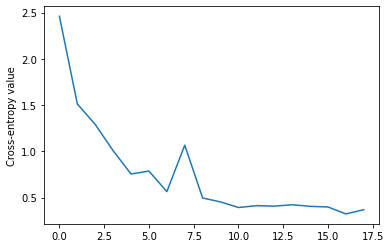

In [26]:
plt.plot(hist_loss)
plt.ylabel('Cross-entropy value');

### Accuracy

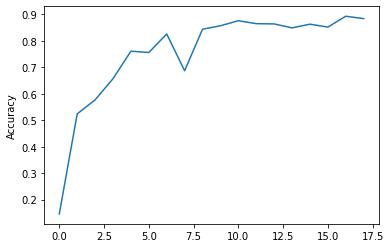

In [27]:
plt.plot(hist_accuracy)
plt.ylabel('Accuracy');

# Tests

Network answer is 0
Right answer is   0


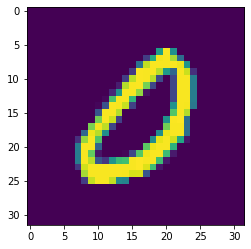

In [28]:
n = 17

plt.imshow(x_train[n][0])
answ = net.forward(x_train[n][:, np.newaxis]).argmax()
print(f'Network answer is {answ}')
print(f'Right answer is   {int(y_train[n, 0])}' )

3

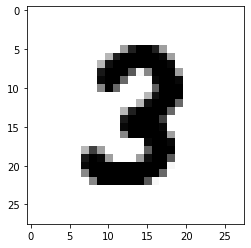

In [29]:
# Image 28x28
image = mpimg.imread('mnist/mypicture.png')
plt.imshow(image)

matrix_img = np.array(1 - image[:,:, 0])[np.newaxis, np.newaxis]
matrix_img = np.pad(matrix_img, padding)
net.forward(matrix_img).argmax()